# Comparing git embeddings of native structures and generated ones

In [1]:
import os, sys
import json
import logging
from typing import *

import numpy as np
import pandas as pd
import umap
from matplotlib import pyplot as plt
import seaborn as sns

from foldingdiff import plotting

SAMPLED_GIT_FNAME = "/home/wukevin/projects/protdiff_results/generation-random-seed-reps/generation_seed_7344/sampled_pdb_git_scores.txt"
TEST_GIT_FNAME = "/home/wukevin/projects/protdiff_results/generation-random-seed-reps/data_splits/test_files.git"

PLOT_DIR = os.path.join(plotting.PLOT_DIR, "git_umap")
assert os.path.isdir(PLOT_DIR)

In [2]:
sampled_metadata_df = pd.read_csv(
    "/home/wukevin/projects/protdiff_results/generation-random-seed-reps/generation_seed_7344/sctm_scores_proteinmpnn_tm_scores.csv",
    index_col=1,
).drop(columns=["Unnamed: 0"])
sampled_metadata_df.head()

scTM  max training TM  length_int  alpha_counts  \
id                                                                  
generated_202  0.39745          0.46674          70             1   
generated_414  0.36039          0.46756          91             2   
generated_309  0.49600          0.60337          80             4   
generated_529  0.29100          0.36524         102             0   
generated_194  0.42942          0.47160          69             3   

               beta_counts                                    scTM best match  \
id                                                                              
generated_202            3  omegafold_predictions_proteinmpnn/generated_20...   
generated_414            2  omegafold_predictions_proteinmpnn/generated_41...   
generated_309            0  omegafold_predictions_proteinmpnn/generated_30...   
generated_529            6  omegafold_predictions_proteinmpnn/generated_52...   
generated_194            2  omegafold_predictions_proteinmpnn/generated_19...   

                                       max training TM structure  \
id                                                                 
generated_202  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_414  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_309  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_529  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_194  /home/wukevin/projects/protdiff/data/cath/domp...   

                             length  designable  
id                                               
generated_202  short ($\leq 70$ aa)       False  
generated_414      long ($> 70$ aa)       False  
generated_309      long ($> 70$ aa)       False  
generated_529      long ($> 70$ aa)       False  
generated_194  short ($\leq 70$ aa)       False

In [3]:
def read_git(fname: str, min_length: int = 0, max_length: int = 0, index_name_func: Optional[Callable] = None) -> pd.DataFrame:
    """Read the embedding in the given git file"""
    retval = pd.read_csv(fname, index_col=0, sep=" ", header=None)
    retval.dropna(axis=1, how="all", inplace=True)
    # retval.drop(columns=[2], inplace=True)
    retval.columns = ['length'] + [f'git{i}' for i in range(1, 32)]

    if max_length > 0:
        retval = retval[retval['length'] <= max_length]
    if min_length > 0:
        retval = retval[retval['length'] >= min_length]

    if index_name_func is not None:
        retval.index = [index_name_func(f) for f in retval.index]
    
    return retval

test_git_values = read_git(
    TEST_GIT_FNAME,
    max_length=128,
    min_length=50,
    index_name_func=lambda x: "test_" + os.path.basename(x).split('.')[0]
).drop(columns=['length'])
test_git_values

git1      git2     git3      git4     git5      git6  \
test_4liqE05  88.7008   -7.0795 -67.4595  175.9496  44.9703  152.2140   
test_4it4A02  85.9557   17.1122  15.3303   39.9423 -84.9125   32.9047   
test_2ma6A00  75.2265  -26.9872 -50.1646  111.9611  -3.5762  100.1624   
test_4xvhA01  90.7239 -132.6650 -54.6832  158.1341  36.9628  142.8357   
test_1oxjA02  91.2857   14.6940  22.2869   56.9435 -60.4322   40.7287   
...               ...       ...      ...       ...      ...       ...   
test_1jb3A00  96.0569  186.2827  -3.4291  154.4794  44.1466  142.2261   
test_1dgjA01  80.2302  -44.3893 -48.8186  109.3161  -5.9504  110.1025   
test_4ak2A01  93.4665   48.9853 -14.4148  143.0355  29.1794  123.7964   
test_4hj1C03  86.5808   73.1550  39.7509  205.6640  53.9248  162.1326   
test_2j7nA02  82.3425    1.5108 -19.4897   67.4673 -59.4803   49.9531   

                 git7     git8      git9    git10  ...    git22    git23  \
test_4liqE05 -56.9205 -45.9189  111.5494 -59.5553  ... -19.3715   6.3347   
test_4it4A02  16.9357  37.2867   22.7621  14.7175  ...   1.4672   5.3917   
test_2ma6A00 -14.0573 -45.8147   97.2583 -33.6637  ...   1.1521  -5.2552   
test_4xvhA01 -59.9838 -38.7119  101.8756 -39.1888  ...  13.0999  29.2185   
test_1oxjA02  22.5295  43.4806   35.9202  19.1511  ...   6.8592   7.3778   
...               ...      ...       ...      ...  ...      ...      ...   
test_1jb3A00 -83.6292 -25.8129  100.0151 -42.5064  ... -14.5449  27.9511   
test_1dgjA01 -28.7198 -33.6970   89.5622 -17.4990  ... -10.7486  -7.9609   
test_4ak2A01  18.3892 -25.7694   96.9449 -39.0472  ...   0.1846   3.7016   
test_4hj1C03  34.3389 -10.3743  123.9065 -46.1911  ...   4.2163  -4.7766   
test_2j7nA02  -2.0801  -6.0164   43.4857  -1.0239  ...  -0.1894  -1.7040   

                git24    git25    git26    git27    git28    git29    git30  \
test_4liqE05   7.7099 -14.5269 -18.1952 -18.3577  -8.1440  13.2581 -18.5801   
test_4it4A02   6.3819  12.8328  -8.8636   1.2247 -10.4796   3.7918   8.6775   
test_2ma6A00  -6.6538  -0.4398 -25.9866  16.8555  13.1041  11.4870 -16.5445   
test_4xvhA01 -11.8138  23.1287 -13.9015   5.1094 -19.7386   1.2397   0.0512   
test_1oxjA02   6.9026   9.0953 -10.6689   6.4309  -3.1305   3.8776   1.3234   
...               ...      ...      ...      ...      ...      ...      ...   
test_1jb3A00   2.8253 -22.9834  12.9703 -19.0574 -13.0981   8.9363  14.6129   
test_1dgjA01   2.7241  -0.0456  -5.4084  -2.7517   7.6460   4.4186  -0.9874   
test_4ak2A01  -8.5610  -8.3723  10.5023   3.1270   9.0585  -2.9710  -5.1623   
test_4hj1C03 -10.3416   9.3461   7.0049   3.5938   6.1094   8.3395 -14.3631   
test_2j7nA02   2.2313   1.7147   4.2123   4.2856   3.3088  -5.1945  -4.3904   

                git31  
test_4liqE05  31.6878  
test_4it4A02   7.2923  
test_2ma6A00   8.5703  
test_4xvhA01   4.4938  
test_1oxjA02   8.5448  
...               ...  
test_1jb3A00  14.7139  
test_1dgjA01   9.2385  
test_4ak2A01   7.2621  
test_4hj1C03 -10.1121  
test_2j7nA02  -0.7010  

[847 rows x 31 columns]

In [4]:
with open("/home/wukevin/projects/protdiff_results/generation-random-seed-reps/generation_seed_7344/ss_cooccurrence_test.json") as source:
    test_metadata = json.load(source)
test_metadata_df = pd.DataFrame(
    -1,
    index=test_git_values.index,
    columns=["alpha_counts", "beta_counts", ]
)
for key, pair in test_metadata.items():
    idx = f"test_{key}"
    if idx in test_metadata_df.index:
        test_metadata_df.loc[idx, "alpha_counts"] = pair[0]
        test_metadata_df.loc[idx, "beta_counts"] = pair[1]
assert not np.any(test_metadata_df == -1)  # No unfilled values
test_metadata_df

alpha_counts  beta_counts
test_4liqE05             0            5
test_4it4A02             3            0
test_2ma6A00             1            0
test_4xvhA01             0            4
test_1oxjA02             5            0
...                    ...          ...
test_1jb3A00             3            6
test_1dgjA01             1            1
test_4ak2A01             0            5
test_4hj1C03             0            8
test_2j7nA02             2            0

[847 rows x 2 columns]

In [5]:
sampled_git_values = read_git(
    SAMPLED_GIT_FNAME,
    max_length=128,
    index_name_func=lambda x: os.path.basename(x).split('.')[0]    
).drop(columns=['length'])
sampled_git_values

git1     git2     git3      git4     git5      git6  \
generated_141  76.4400   3.8453  27.7331   95.9754 -19.5961   99.5244   
generated_78   73.5449  16.3872  32.2376   59.7064 -54.9966   43.9128   
generated_317  82.6842 -14.5293  -3.3797   38.6942 -80.6911   32.2620   
generated_777  96.0569  28.5094   6.2355   42.0266 -55.5323   32.3201   
generated_739  95.0377 -28.0400   1.7799   87.0122 -22.4641   60.8103   
...                ...      ...      ...       ...      ...       ...   
generated_412  85.9557  -9.5015  -7.6106   45.2029 -68.4553   44.3092   
generated_469  87.5020  11.9892  -0.0977   41.6783 -74.8897   31.5412   
generated_352  84.0234  96.8247 -41.3305  119.6608   3.4791  118.7693   
generated_403  85.6396  33.3539   5.7698   51.1711 -61.1415   41.0021   
generated_614  91.8407   2.1431  -0.8324   19.2937 -91.4547   12.7178   

                  git7     git8     git9    git10  ...    git22    git23  \
generated_141  23.3804 -24.8226  62.0038 -41.5870  ...   5.9730  19.0066   
generated_78   15.5008  39.0500  44.0162  11.6113  ...  10.1222   4.4595   
generated_317 -14.2275 -27.1740  33.5408 -11.3089  ...  -9.7897  -2.3585   
generated_777  10.4040  12.6984  36.1285  -0.2309  ...  -2.2745  11.1458   
generated_739 -38.1831 -11.8388  58.7658  -1.4970  ...   6.4769  -4.9645   
...                ...      ...      ...      ...  ...      ...      ...   
generated_412   3.4334   6.8629  39.5239   7.4617  ...   3.8797   1.0913   
generated_469  10.8185  19.2714  36.1626   7.4669  ...   6.8933   3.7119   
generated_352 -55.8818 -24.3871  88.4819 -40.8572  ... -31.4139 -14.4974   
generated_403  33.2039  44.9342  47.3677  10.8915  ...  -9.2763   5.9147   
generated_614  -0.7191  -5.4804  21.6034  -1.4769  ...  -0.3105  -0.1406   

                 git24    git25    git26    git27    git28    git29    git30  \
generated_141 -31.9792  19.6185  -1.5758   9.2981  13.1677   7.0275 -18.2099   
generated_78    0.9935   3.9819  -6.1802   5.3006   1.8850  -3.3904   2.4627   
generated_317  -5.5974  -4.5933   1.3531  -4.1334   8.8174  -1.9603  -4.0869   
generated_777 -24.6993 -12.2879  12.3937 -10.6704   8.9478  -3.2531  -4.9211   
generated_739 -15.4264   1.3001  -2.1385   7.9160  -2.7347  30.5249  -2.1616   
...                ...      ...      ...      ...      ...      ...      ...   
generated_412  -1.2945   0.5016   7.3066  -0.3257  -2.9291  -3.5356  -2.5669   
generated_469   3.3838  -2.5662   4.4806   2.1716  -4.3140   1.9232   0.1786   
generated_352 -14.6263  82.1354 -30.0520  27.0873 -16.6189  22.7924 -18.3259   
generated_403  12.2056  -3.3280  18.8644   3.2696  -3.4828  -8.9197 -36.8232   
generated_614  -0.2852  -0.2276  -0.5261   0.7333   0.2660  -0.2895   0.0447   

                 git31  
generated_141  -8.5431  
generated_78   -1.1261  
generated_317   1.1670  
generated_777  10.7228  
generated_739   5.5616  
...                ...  
generated_412   7.1494  
generated_469  -1.2993  
generated_352   0.2716  
generated_403 -10.3090  
generated_614   0.2106  

[780 rows x 31 columns]

# Plots of sampled only

In [6]:
SEED = int(
    float.fromhex("2254616977616e2069732061206672656520636f756e74727922") % 10000
)

def umap_embed(values, seed: int = SEED):
    return pd.DataFrame(
        umap.UMAP(random_state=seed).fit_transform(values),
        index=values.index if isinstance(values, pd.DataFrame) else None,
        columns=["UMAP1", "UMAP2"],
    )

sampled_git_umap = umap_embed(sampled_git_values)
sampled_git_umap.head()

UMAP1     UMAP2
generated_141  8.330459  2.449387
generated_78   6.006385  3.726113
generated_317  7.700311 -0.666547
generated_777  5.838839  1.716408
generated_739  9.120504  1.057051

In [7]:
sampled_git_umap = sampled_git_umap.join(sampled_metadata_df, how='inner')
sampled_git_umap

UMAP1     UMAP2     scTM  max training TM  length_int  \
generated_141  8.330459  2.449387  0.37390          0.40044          64   
generated_78   6.006385  3.726113  0.31745          0.41805          57   
generated_317  7.700311 -0.666547  0.24533          0.34459          81   
generated_777  5.838839  1.716408  0.30546          0.53527         127   
generated_739  9.120504  1.057051  0.28823          0.50030         123   
...                 ...       ...      ...              ...         ...   
generated_412  6.100042  1.122796  0.31349          0.45657          91   
generated_469  4.989552  1.873322  0.46639          0.59022          96   
generated_352  8.373651  2.441434  0.37116          0.45946          85   
generated_403  6.148519  4.033802  0.39327          0.50197          90   
generated_614  5.961668 -1.252967  0.24531          0.40862         111   

               alpha_counts  beta_counts  \
generated_141             0            3   
generated_78              1            3   
generated_317             0            4   
generated_777             5            3   
generated_739             4            3   
...                     ...          ...   
generated_412             4            2   
generated_469             4            0   
generated_352             1            5   
generated_403             2            3   
generated_614             1            5   

                                                 scTM best match  \
generated_141  omegafold_predictions_proteinmpnn/generated_14...   
generated_78   omegafold_predictions_proteinmpnn/generated_78...   
generated_317  omegafold_predictions_proteinmpnn/generated_31...   
generated_777  omegafold_predictions_proteinmpnn/generated_77...   
generated_739  omegafold_predictions_proteinmpnn/generated_73...   
...                                                          ...   
generated_412  omegafold_predictions_proteinmpnn/generated_41...   
generated_469  omegafold_predictions_proteinmpnn/generated_46...   
generated_352  omegafold_predictions_proteinmpnn/generated_35...   
generated_403  omegafold_predictions_proteinmpnn/generated_40...   
generated_614  omegafold_predictions_proteinmpnn/generated_61...   

                                       max training TM structure  \
generated_141  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_78   /home/wukevin/projects/protdiff/data/cath/domp...   
generated_317  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_777  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_739  /home/wukevin/projects/protdiff/data/cath/domp...   
...                                                          ...   
generated_412  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_469  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_352  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_403  /home/wukevin/projects/protdiff/data/cath/domp...   
generated_614  /home/wukevin/projects/protdiff/data/cath/domp...   

                             length  designable  
generated_141  short ($\leq 70$ aa)       False  
generated_78   short ($\leq 70$ aa)       False  
generated_317      long ($> 70$ aa)       False  
generated_777      long ($> 70$ aa)       False  
generated_739      long ($> 70$ aa)       False  
...                             ...         ...  
generated_412      long ($> 70$ aa)       False  
generated_469      long ($> 70$ aa)       False  
generated_352      long ($> 70$ aa)       False  
generated_403      long ($> 70$ aa)       False  
generated_614      long ($> 70$ aa)       False  

[780 rows x 11 columns]

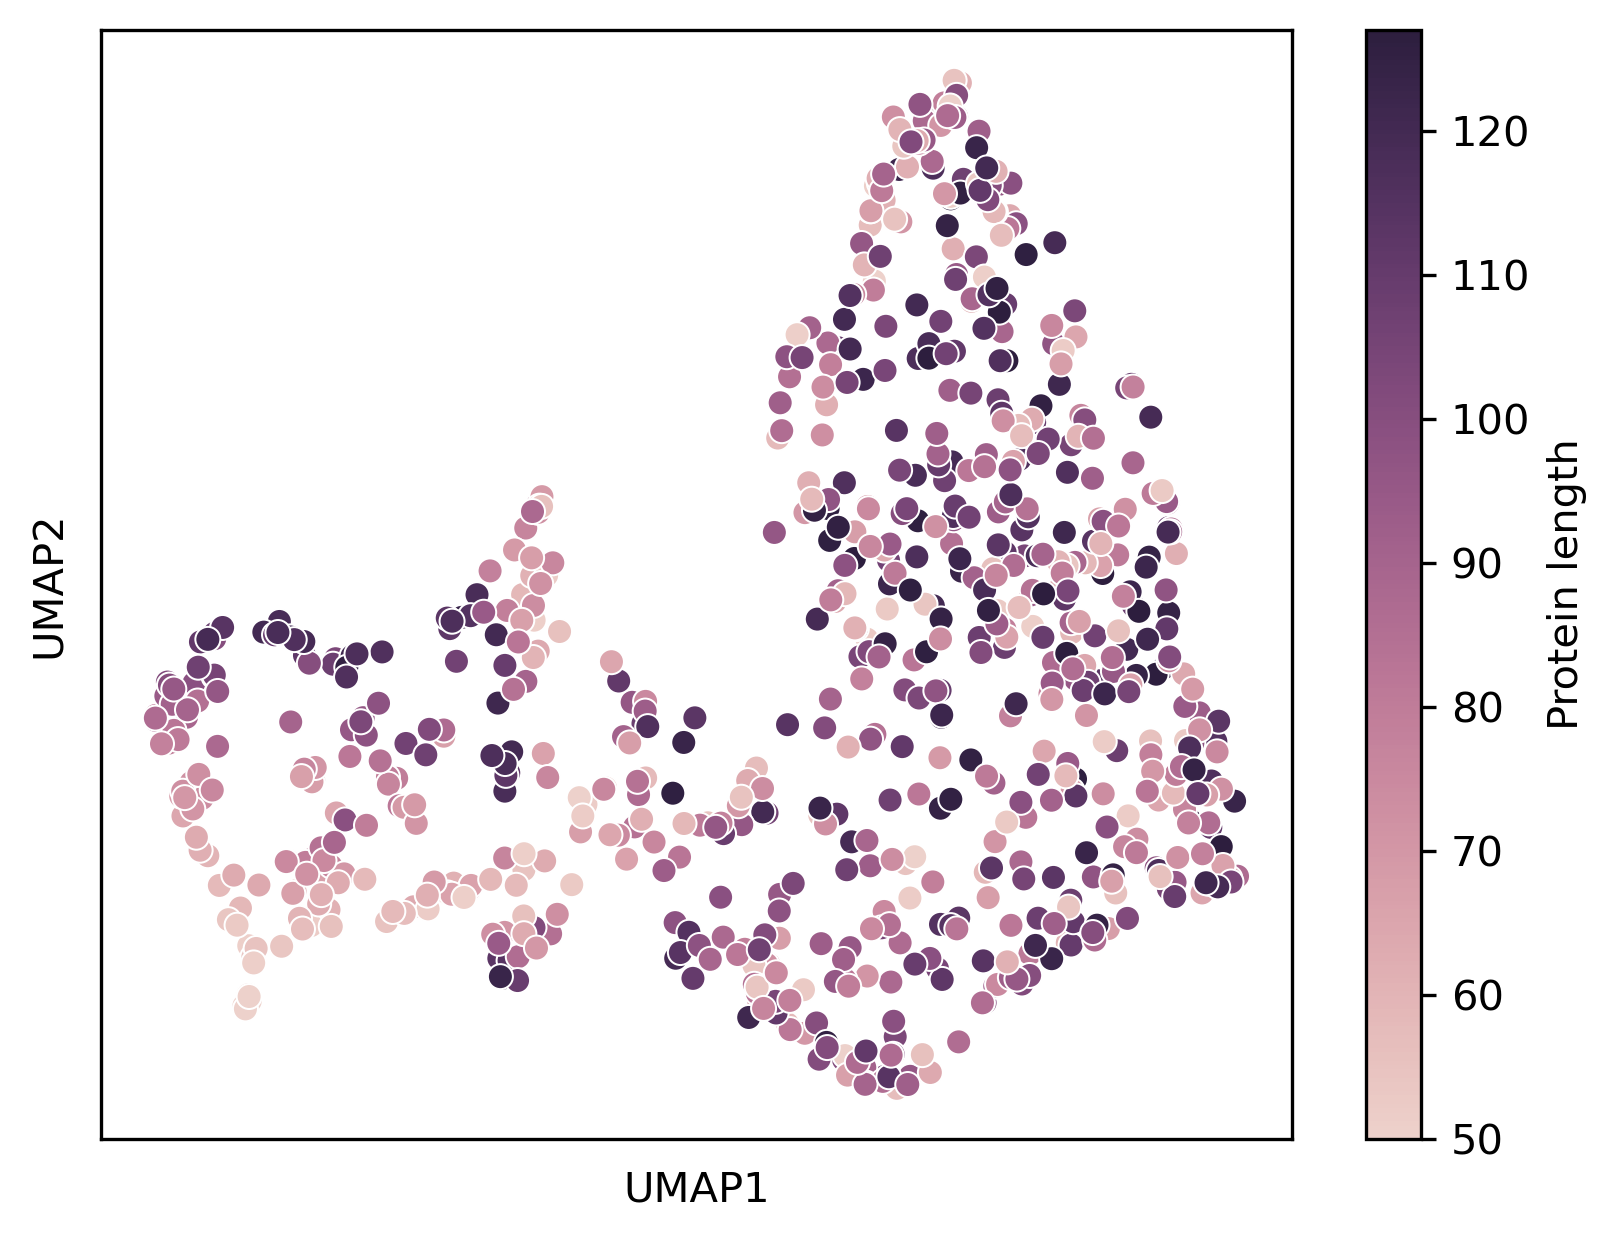

In [8]:
fig, ax = plt.subplots(dpi=300)
norm = plt.Normalize(sampled_git_umap['length_int'].min(), sampled_git_umap['length_int'].max())
sns.scatterplot(
    data=sampled_git_umap,
    x='UMAP1',
    y='UMAP2',
    hue='length_int',
    hue_norm=norm,
    palette=sns.cubehelix_palette(as_cmap=True),
)
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label=r"Protein length")

ax.set(
    xticks=[], yticks=[],
)
fig.savefig(os.path.join(PLOT_DIR, "sampled_git_umap_by_length.pdf"), bbox_inches='tight')
fig.show()

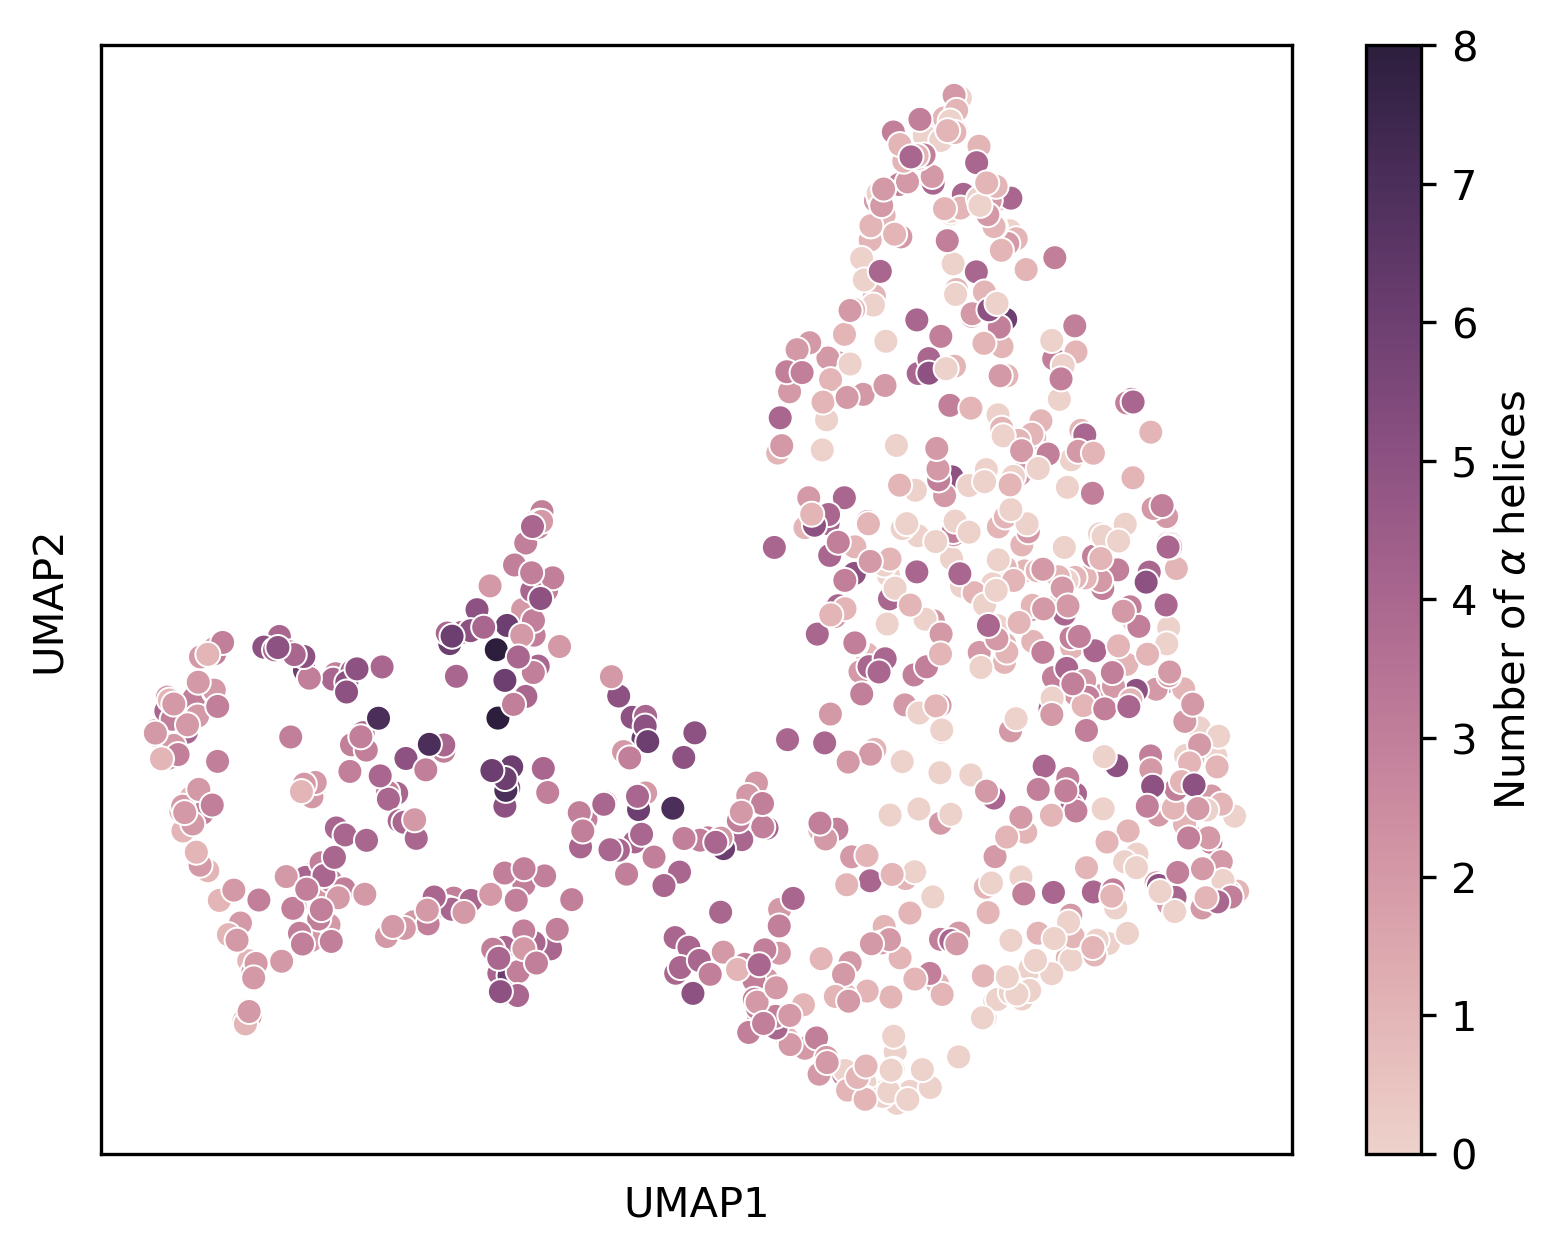

In [9]:
fig, ax = plt.subplots(dpi=300)
norm = plt.Normalize(sampled_git_umap['alpha_counts'].min(), sampled_git_umap['alpha_counts'].max())
sns.scatterplot(
    data=sampled_git_umap,
    x='UMAP1',
    y='UMAP2',
    hue='alpha_counts',
    hue_norm=norm,
    palette=sns.cubehelix_palette(as_cmap=True),
)
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label=r"Number of $\alpha$ helices")

ax.set(
    xticks=[], yticks=[],
)
fig.savefig(os.path.join(PLOT_DIR, "sampled_git_umap_by_alpha.pdf"), bbox_inches='tight')
fig.show()

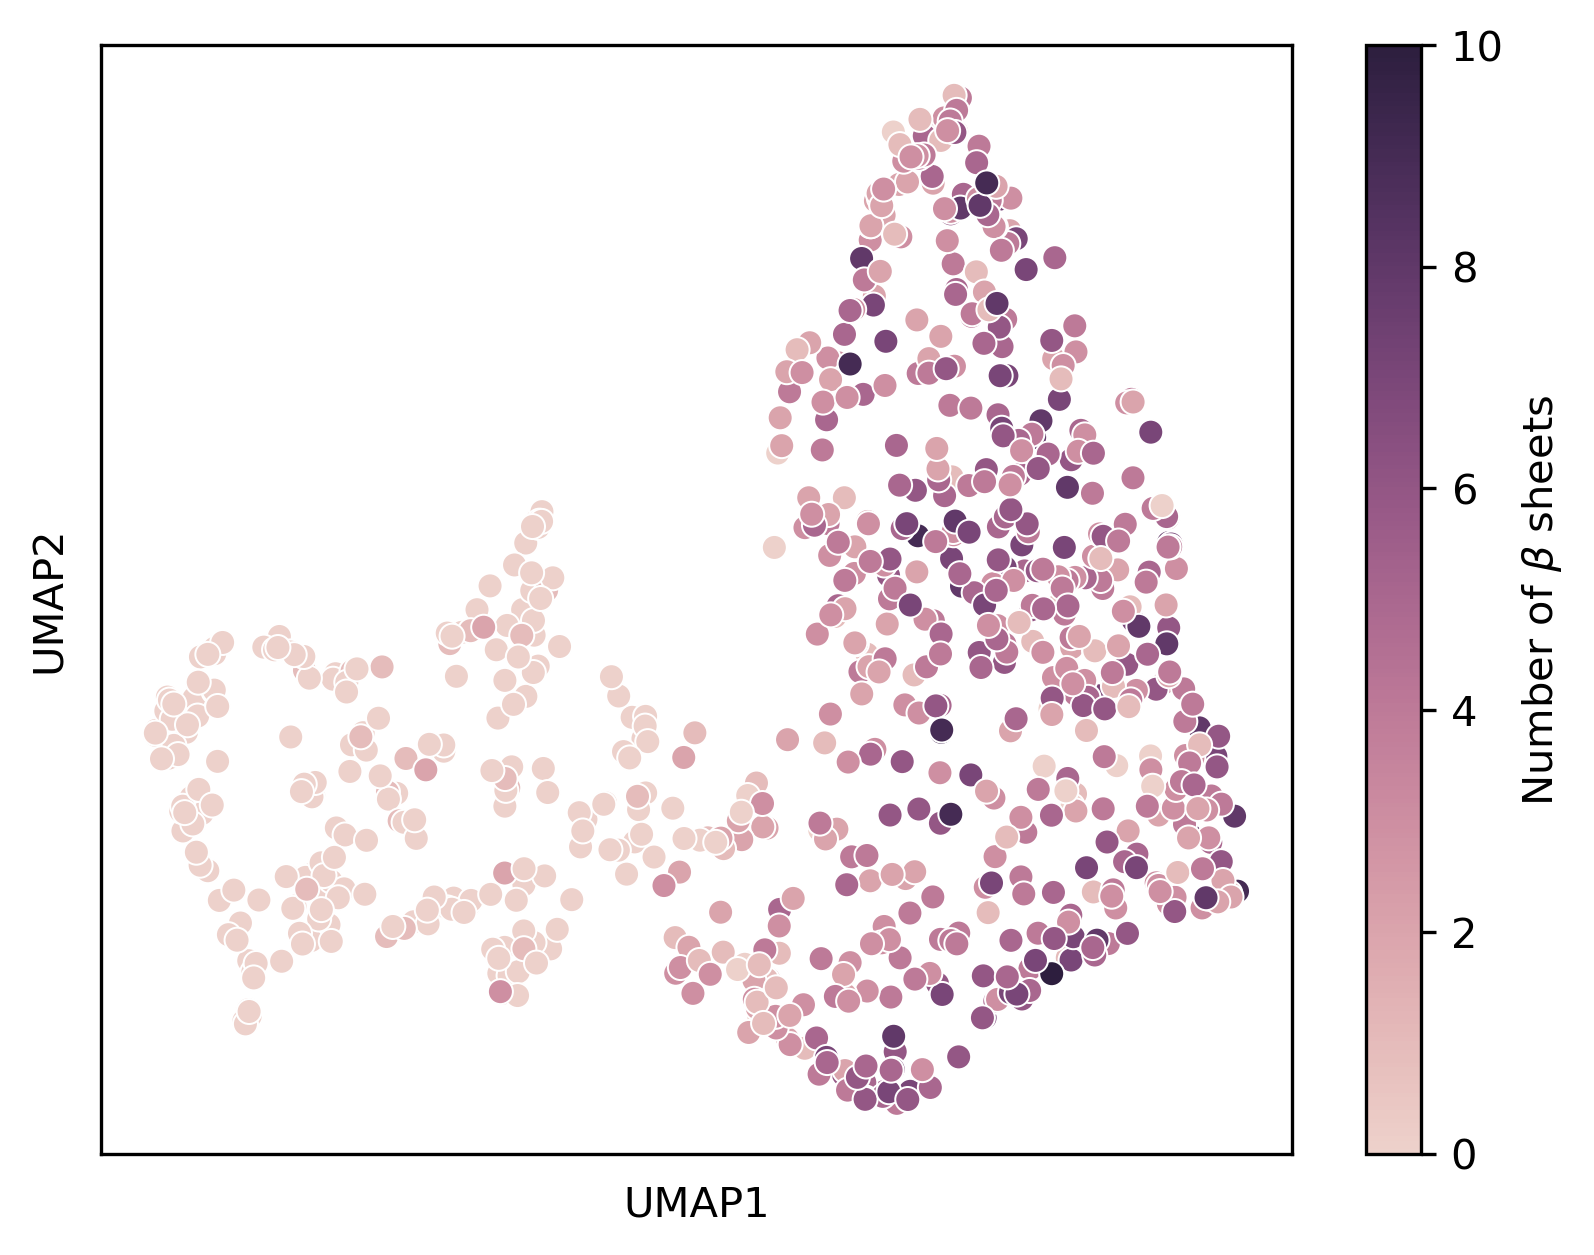

In [10]:
fig, ax = plt.subplots(dpi=300)
norm = plt.Normalize(sampled_git_umap['beta_counts'].min(), sampled_git_umap['beta_counts'].max())
sns.scatterplot(
    data=sampled_git_umap,
    x='UMAP1',
    y='UMAP2',
    hue='beta_counts',
    hue_norm=norm,
    palette=sns.cubehelix_palette(as_cmap=True),
)
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label=r"Number of $\beta$ sheets")
ax.get_legend().remove()

ax.set(
    xticks=[], yticks=[],
)
fig.savefig(os.path.join(PLOT_DIR, "sampled_git_umap_by_beta.pdf"), bbox_inches='tight')
fig.show()

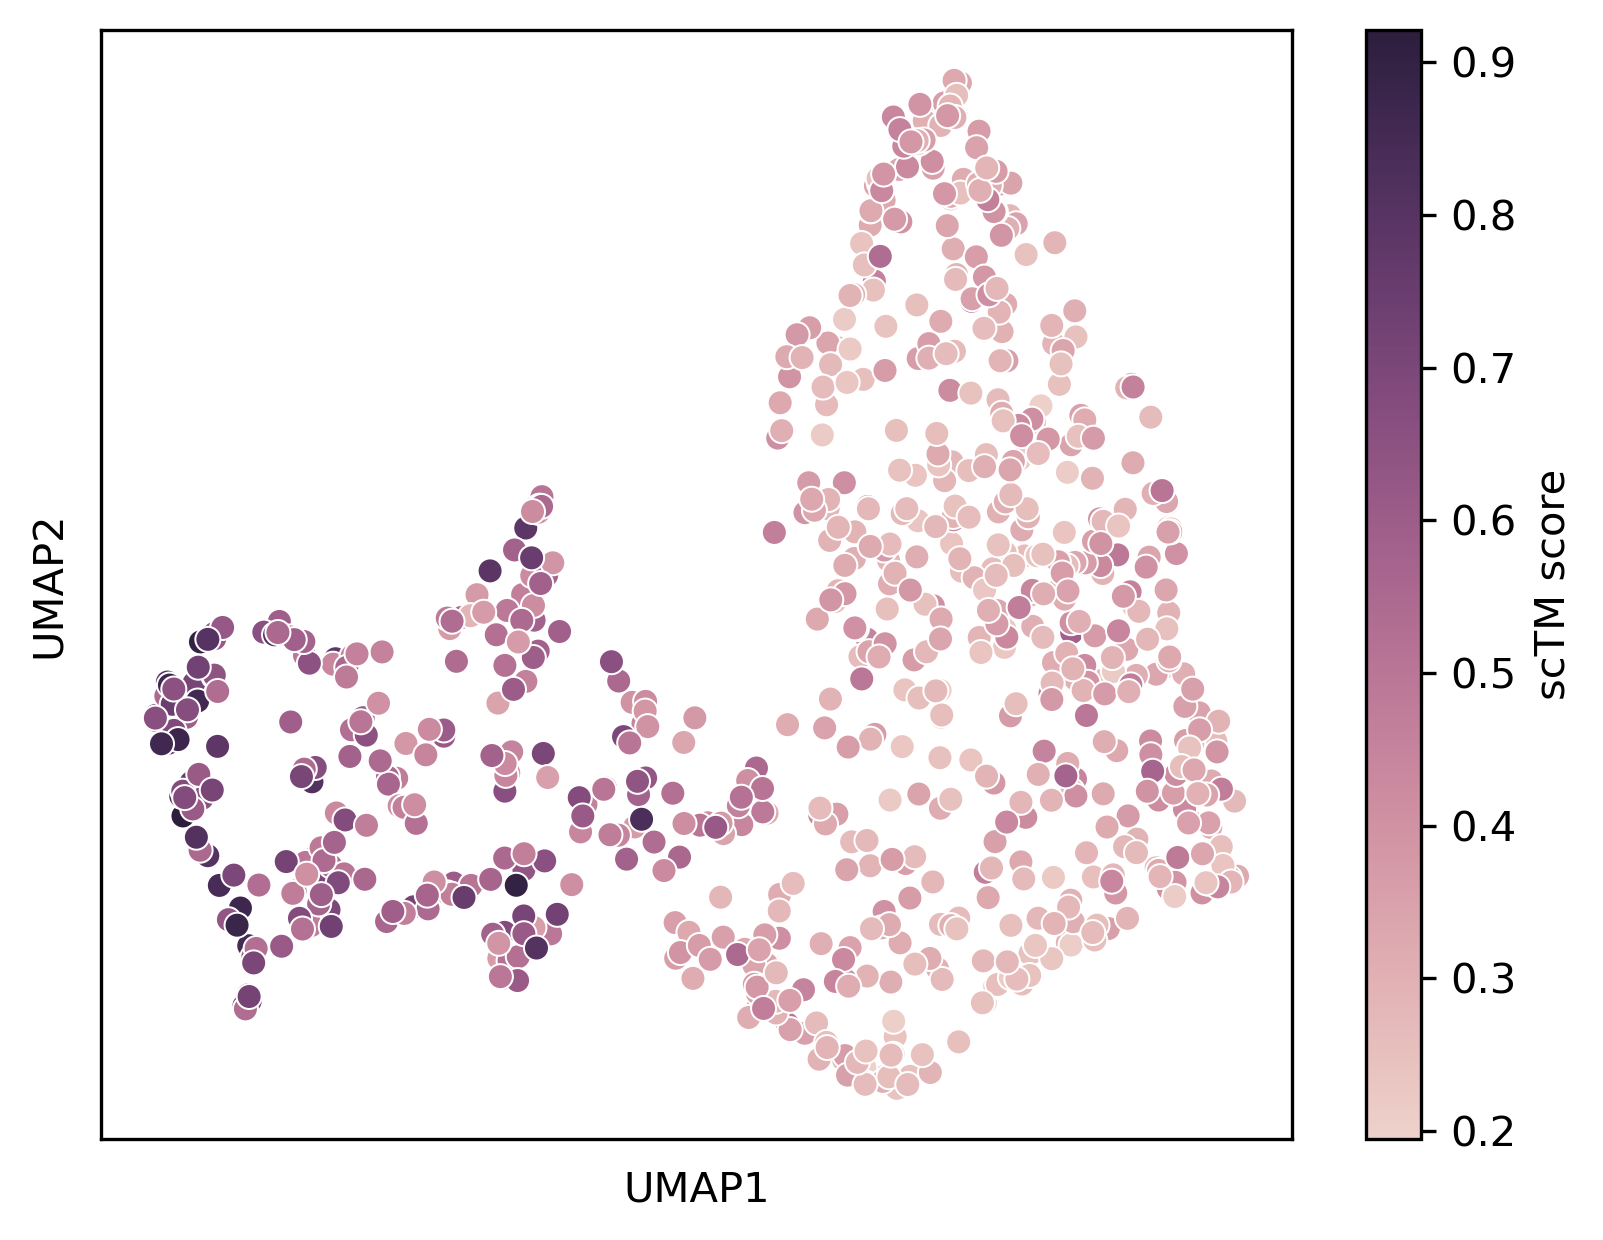

In [11]:
fig, ax = plt.subplots(dpi=300)
norm = plt.Normalize(sampled_git_umap['scTM'].min(), sampled_git_umap['scTM'].max())
sns.scatterplot(
    data=sampled_git_umap,
    x='UMAP1',
    y='UMAP2',
    hue='scTM',
    hue_norm=norm,
    palette=sns.cubehelix_palette(as_cmap=True),
    ax=ax,
)
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label="scTM score")

ax.set(
    xticks=[], yticks=[],
)
fig.savefig(os.path.join(PLOT_DIR, "sampled_git_umap_by_sctm.pdf"), bbox_inches='tight')
fig.show()

# Combined plots

In [12]:
combined_metadata_df = pd.concat([sampled_metadata_df, test_metadata_df], axis=0, join='inner')
combined_metadata_df

alpha_counts  beta_counts
generated_202             1            3
generated_414             2            2
generated_309             4            0
generated_529             0            6
generated_194             3            2
...                     ...          ...
test_1jb3A00              3            6
test_1dgjA01              1            1
test_4ak2A01              0            5
test_4hj1C03              0            8
test_2j7nA02              2            0

[1627 rows x 2 columns]

In [13]:
combined_umap = umap_embed(pd.concat([test_git_values, sampled_git_values]))
combined_umap.head()

UMAP1     UMAP2
test_4liqE05  11.419374  3.813149
test_4it4A02   4.466052  8.709891
test_2ma6A00  10.181295  3.503077
test_4xvhA01  10.108700  1.616123
test_1oxjA02   5.099641  8.601936

In [14]:
combined_umap['source'] = [i.split('_')[0] for i in combined_umap.index]
combined_umap = combined_umap.join(combined_metadata_df, how='inner')
combined_umap

UMAP1     UMAP2     source  alpha_counts  beta_counts
test_4liqE05   11.419374  3.813149       test             0            5
test_4it4A02    4.466052  8.709891       test             3            0
test_2ma6A00   10.181295  3.503077       test             1            0
test_4xvhA01   10.108700  1.616123       test             0            4
test_1oxjA02    5.099641  8.601936       test             5            0
...                  ...       ...        ...           ...          ...
generated_412   4.805202  6.143592  generated             4            2
generated_469   3.510618  8.002620  generated             4            0
generated_352  10.708916  5.963565  generated             1            5
generated_403   6.146467  7.955847  generated             2            3
generated_614   3.275116  4.892844  generated             1            5

[1627 rows x 5 columns]

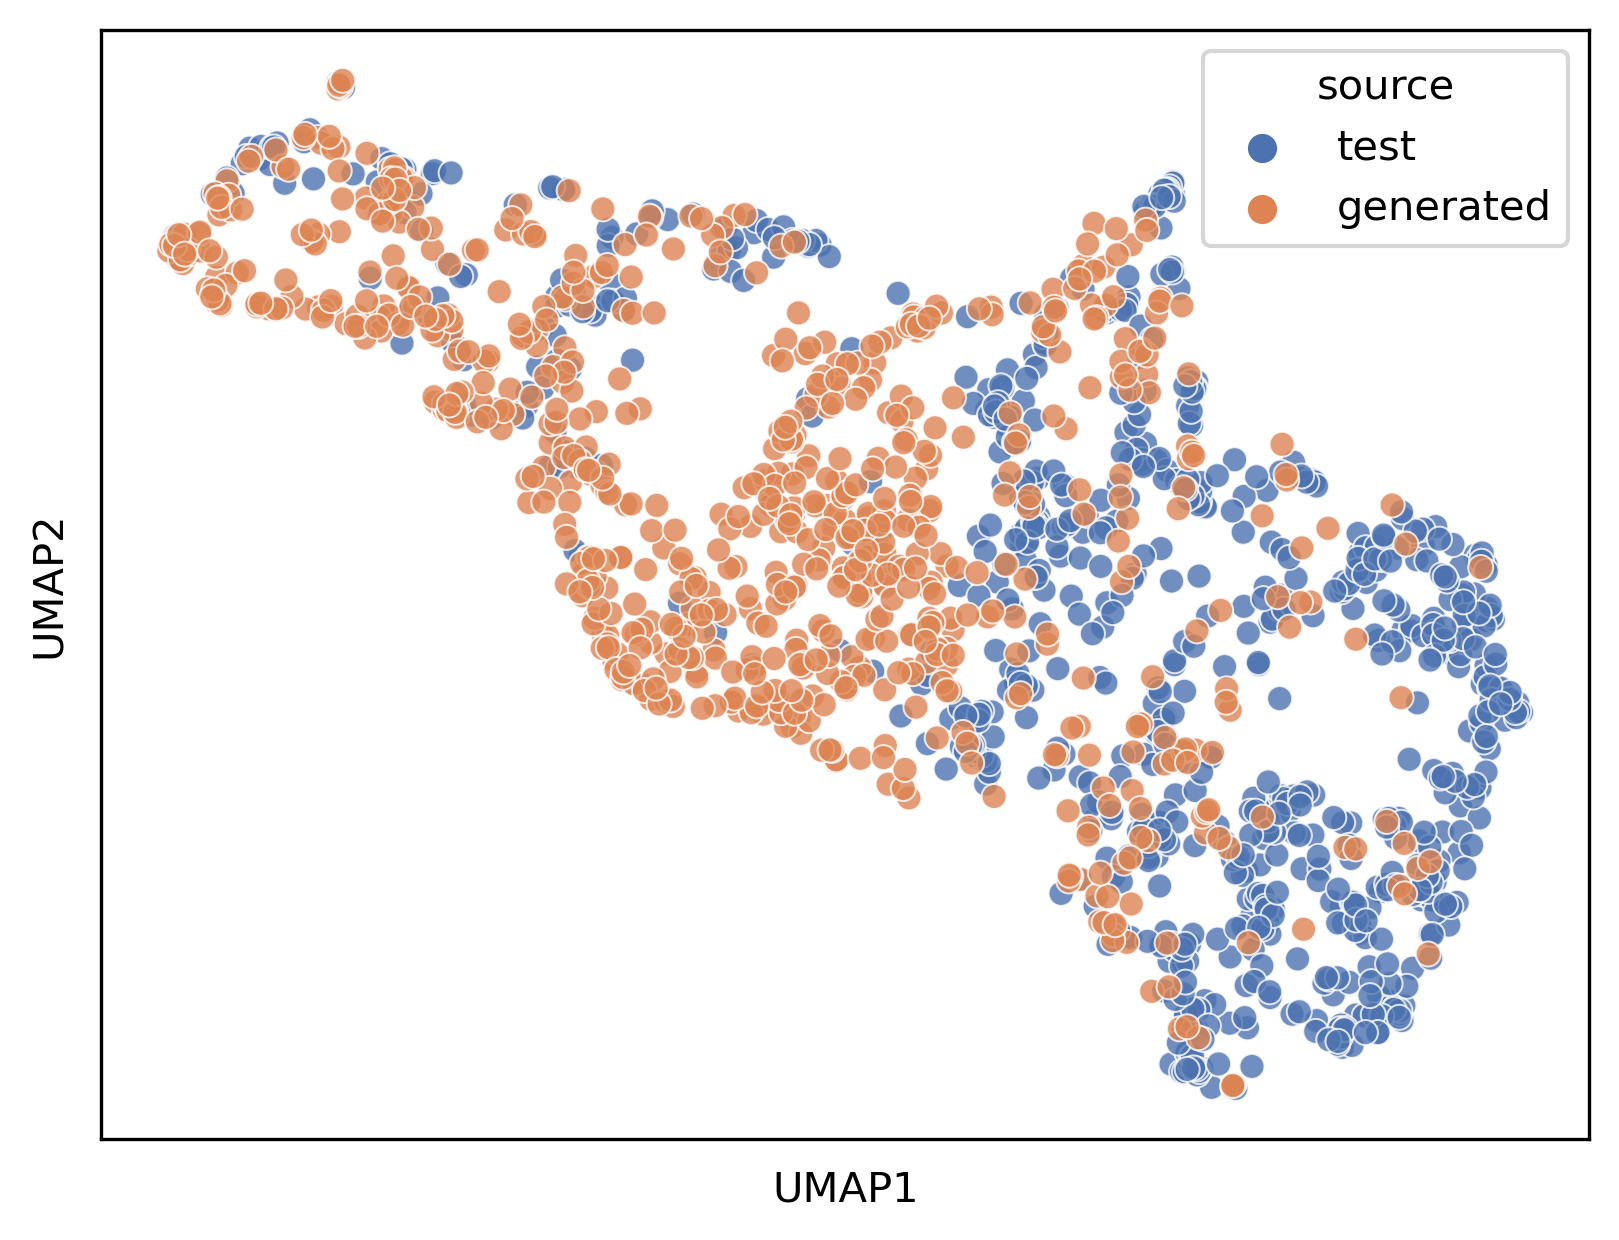

In [15]:
fig, ax = plt.subplots(dpi=300)
sns.scatterplot(
    data=combined_umap, x='UMAP1', y='UMAP2',
    hue="source",
    palette=sns.color_palette("deep", n_colors=2),
    alpha=0.8,
    ax=ax,
)
ax.set(
    xticks=[], yticks=[],
)
fig.savefig(os.path.join(PLOT_DIR, "combined_git_umap_by_source.pdf"), bbox_inches='tight')
fig.show()

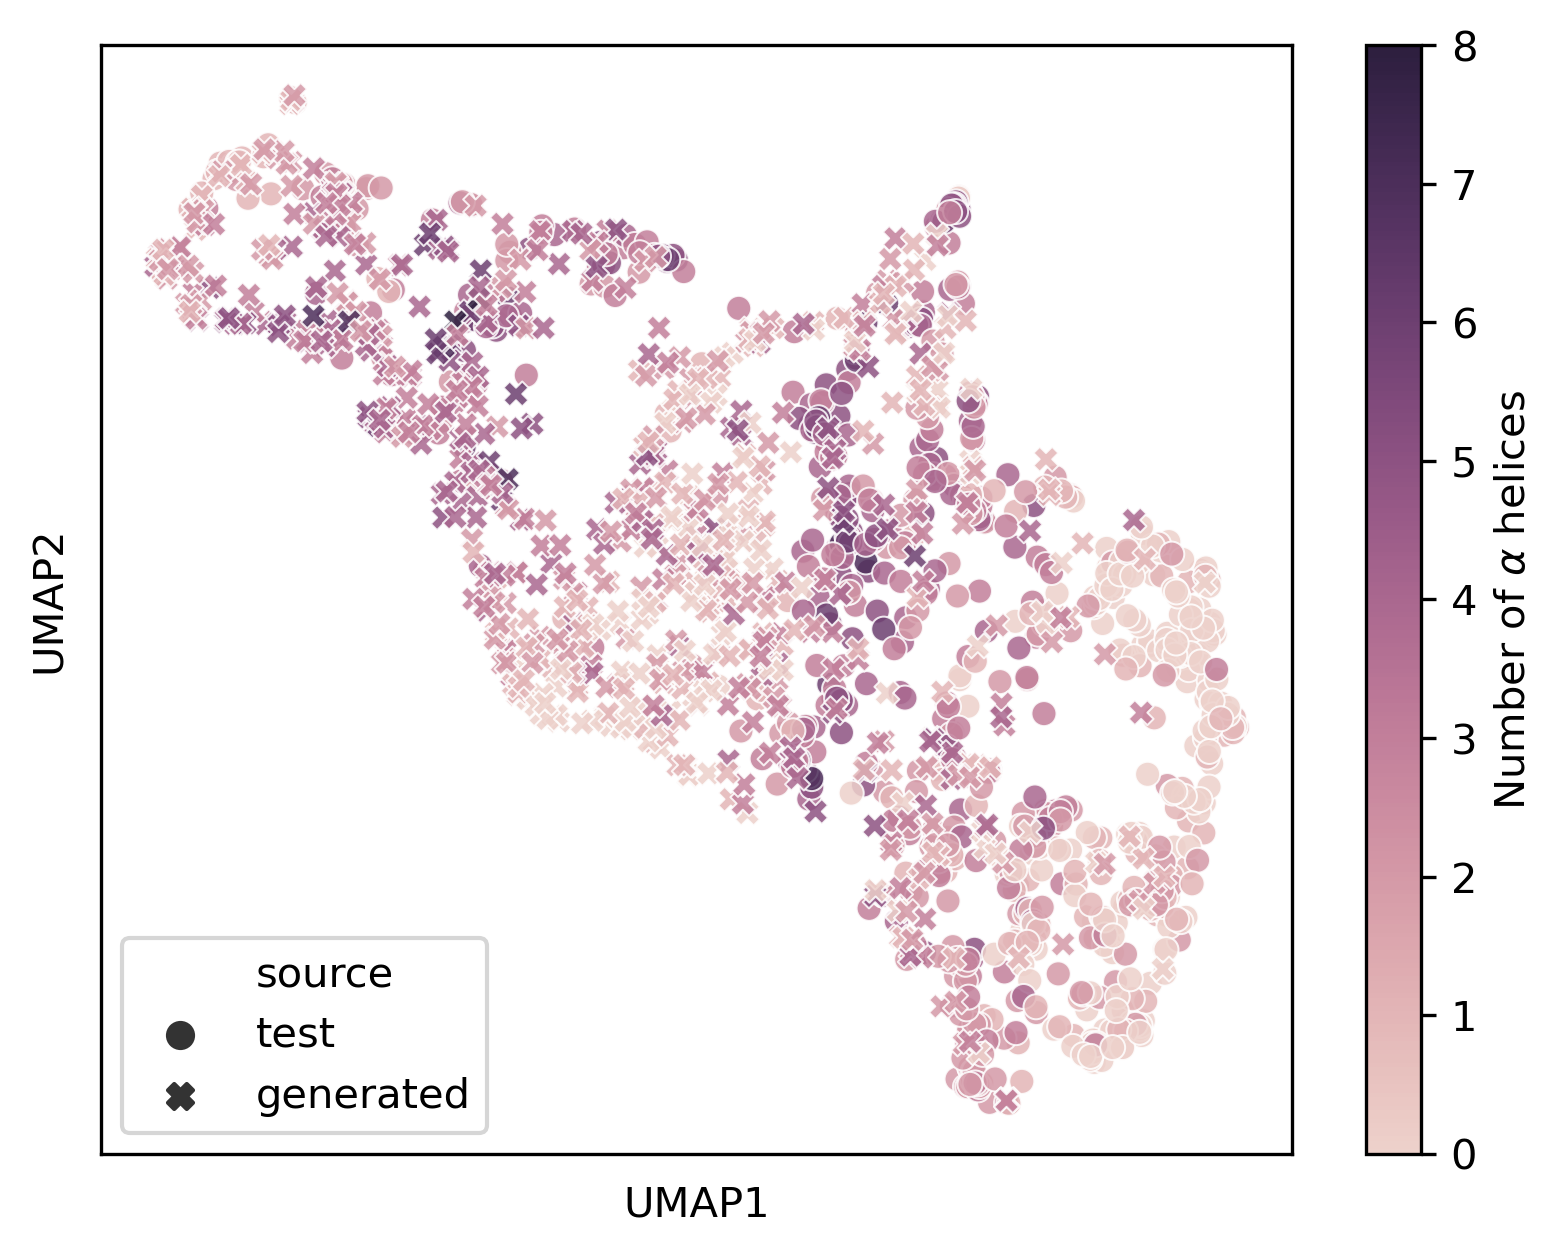

In [16]:
fig, ax = plt.subplots(dpi=300)
norm = plt.Normalize(combined_umap['alpha_counts'].min(), combined_umap['alpha_counts'].max())
sns.scatterplot(
    data=combined_umap, x='UMAP1', y='UMAP2',
    hue='alpha_counts',
    hue_norm=norm,
    style="source",
    palette=sns.cubehelix_palette(as_cmap=True),
    alpha=0.85,
    ax=ax,
)
# Segned only for source
h, l = ax.get_legend_handles_labels()
ax.legend(h[-3:], l[-3:], loc='lower left')
# Set colorbar
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label=r"Number of $\alpha$ helices")
ax.set(xticks=[], yticks=[])
fig.savefig(os.path.join(PLOT_DIR, "combined_git_umap_by_alpha.pdf"), bbox_inches='tight')
fig.show()

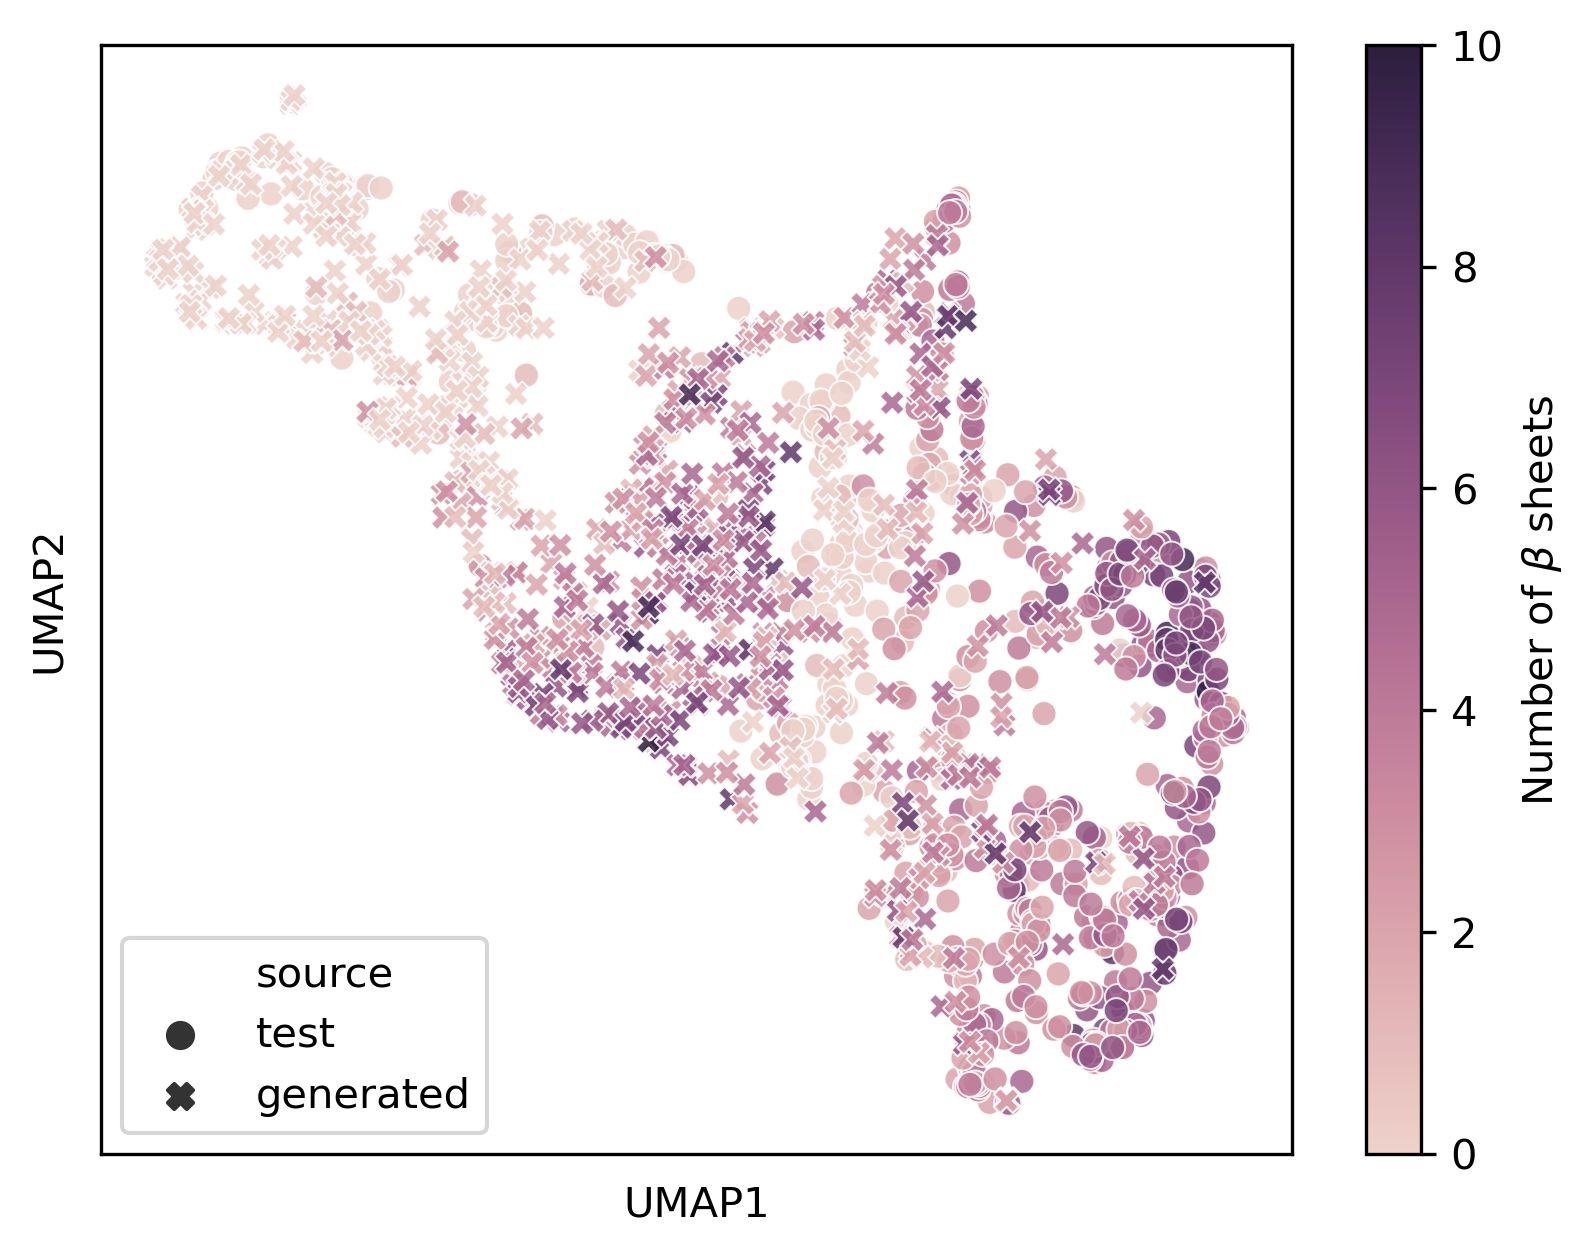

In [17]:
fig, ax = plt.subplots(dpi=300)
norm = plt.Normalize(combined_umap['beta_counts'].min(), combined_umap['beta_counts'].max())
sns.scatterplot(
    data=combined_umap, x='UMAP1', y='UMAP2',
    hue='beta_counts',
    hue_norm=norm,
    style="source",
    palette=sns.cubehelix_palette(as_cmap=True),
    alpha=0.85,
    ax=ax,
)
# Segned only for source
h, l = ax.get_legend_handles_labels()
ax.legend(h[-3:], l[-3:], loc='lower left')
# Set colorbar
sm = plt.cm.ScalarMappable(cmap=sns.cubehelix_palette(as_cmap=True), norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label=r"Number of $\beta$ sheets")
ax.set(xticks=[], yticks=[])
fig.savefig(os.path.join(PLOT_DIR, "combined_git_umap_by_beta.pdf"), bbox_inches='tight')
fig.show()